In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os.path
from os import path
from importlib import reload
import wandb


creds_path_ar = ["credentials.ini","credentials.colab.ini"]
PATH_ROOT = ""
PATH_DATA = ""

for creds_path in creds_path_ar:
    if path.exists(creds_path):
        config_parser = configparser.ConfigParser()
        config_parser.read(creds_path)
        PATH_ROOT = config_parser['MAIN']["PATH_ROOT"]
        PATH_DATA = config_parser['MAIN']["PATH_DATA"]
        WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
        ENV = config_parser['MAIN']["ENV"]
        break

if ENV=="COLAB":
  from google.colab import drive
  mount_path = '/content/gdrive/'
  drive.mount(mount_path)

In [3]:
if WANDB_enable == True:
    wandb.init(project="sota-mafat-base")
    os.environ['WANDB_NOTEBOOK_NAME'] = '[SS]Alexnet_pytorch'

In [4]:
cd {PATH_ROOT}

C:\SOTA\Mafat


In [5]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from src.data import feat_data, get_data
from src.visualization import specto_vis

from src.models import arch_setup, base_base_model, alex_model

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)


random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

In [10]:
train = get_data.load_data(PATH_DATA+'\\MAFAT RADAR Challenge - Training Set V1')

In [6]:
train_x, train_y, val_x, val_y = get_data.classic_trainval(PATH_DATA)

Please mount drive and set competition_path correctly


In [11]:
humans = train['iq_sweep_burst'][train['target_type']=='human']
animals = train['iq_sweep_burst'][train['target_type']=='animal']

In [12]:
animals.shape

(5757, 128, 32)

In [16]:
 import pywt

def calculate_scalogram(iq_matrix, flip=True, transformation = 'cgau1'):
    '''
    calculate a scalogram matrix that preforms a continues wavelet transformation on the data.

    Arguments:
        iq_matrix (array-like): array of complex signal data, rows represent spatial location, columns time
        flip (bool): optional argument for flipping the row order of the matrix.
        transformation (string): name of wavelet signal to use as mother signal. default to gaussian kernel
    return:
        scalogram: array like transformation that correspond with correlation of different frequency wavelets at different time-points. 
    
    1. select each column of the IQ matrix
    2. apply hann-window smoothing
    3. preform Continues Wavelet Transformation (data, array of psooible scale values, type of transformation)
    '''
    from src.features import specto_feat

    
    scalograms = []
    #analyze each column (time-point) seperatly
    for j in range(iq_matrix.shape[1]):
        # preform hann smoothing on a column - results in a singal j-2 sized column
        # preform py.cwt transformation, returns coefficients and frequencies
        coef, freqs=pywt.cwt(hann(iq_matrix[:, j][:, np.newaxis]), np.arange(1,8), transformation)
        # coefficient matrix returns as a (num_scalers-1, j-2 , 1) array, transform it into a 2-d array

        if flip:
            coef = np.flip(coef, axis=0)
        # log normalization of the data
        coef=np.log(np.abs(coef))
        # first column correspond to the scales, rest is the coefficients
        coef=coef[:, 1:,0]
        coef=coef.T
        scalograms.append(coef)

    stacked_scalogram = np.stack(scalograms)
    stacked_scalogram = np.maximum(np.median(stacked_scalogram) - 1., stacked_scalogram)
    return stacked_scalogram

In [18]:
from src.features import specto_feat
samp = animals[0]
specto_feat.calculate_scalogram(samp).shape
#specto_feat.calculate_spectrogram(samp).shape

(32, 125, 7)

In [128]:

samp_dict = pd.DataFrame(train.values()).iloc[:,:15].join(pd.DataFrame(train.keys()), rsuffix = '_').set_index('0_', drop=True).values

samp_dict = {list(train.keys())[i]:samp_dict[i] for i in range(samp_dict.shape[0])}

In [136]:
specto_feat.data_preprocess(samp_dict,'scalogram')
samp_dict

100%|██████████| 15/15 [00:02<00:00,  6.65it/s]


, -3.78866336,
           -3.78866336, -3.78866336],
          [-3.78866336, -3.78866336, -3.78866336, ..., -3.78866336,
           -3.78866336, -3.78866336],
          [-3.78866336, -3.78866336, -3.78866336, ..., -3.78866336,
           -3.78866336, -3.78866336]]],
 
 
        [[[-4.04144207, -4.04144207, -4.04144207, ..., -4.04144207,
           -4.04144207, -4.04144207],
          [-4.04144207, -4.04144207, -4.04144207, ..., -4.04144207,
           -4.04144207, -4.04144207],
          [-4.04144207, -4.04144207, -4.04144207, ..., -4.04144207,
           -4.04144207, -4.04144207],
          ...,
          [-4.04144207, -4.04144207, -4.04144207, ..., -4.04144207,
           -4.04144207, -4.04144207],
          [-4.04144207, -4.04144207, -4.04144207, ..., -4.04144207,
           -4.04144207, -4.04144207],
          [-4.04144207, -4.04144207, -4.04144207, ..., -4.04144207,
           -4.04144207, -4.04144207]],
 
         [[-4.04144207, -4.04144207, -4.04144207, ..., -4.04144207,
       

In [141]:
samp_dict['iq_sweep_burst'].shape

(15, 32, 123, 7)

Error: when 'parula' color map is used, color_map_path should be provided.
Switching color map to 'viridis'.


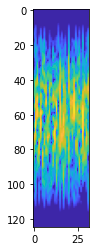

<Figure size 432x288 with 0 Axes>

In [142]:
specto_vis.plot_spectrogram(samp,None,type = 'scalogram')